In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf

from tensorflow import keras

print(tf.__version__)
print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)

2.3.1
sys.version_info(major=3, minor=6, micro=12, releaselevel='final', serial=0)
matplotlib 3.3.2
numpy 1.18.5
pandas 1.1.3
sklearn 0.23.2
tensorflow 2.3.1
tensorflow.keras 2.4.0


In [2]:
fashion_mnist = keras.datasets.fashion_mnist
(x_train_all, y_train_all), (x_test, y_test) = fashion_mnist.load_data()
x_valid, x_train = x_train_all[:5000], x_train_all[5000:]
y_valid, y_train = y_train_all[:5000], y_train_all[5000:]

print(x_valid.shape, y_valid.shape)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(5000, 28, 28) (5000,)
(55000, 28, 28) (55000,)
(10000, 28, 28) (10000,)


In [3]:
# x = (x - u) / std

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
# x_train: [None, 28, 28] -> [None, 784]
x_train_scaled = scaler.fit_transform(
    x_train.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28)
x_valid_scaled = scaler.transform(
    x_valid.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28)
x_test_scaled = scaler.transform(
    x_test.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28)


In [4]:
# tf.keras.models.Sequential()

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
for _ in range(20):
    model.add(keras.layers.Dense(100, activation='selu'))
model.add(keras.layers.AlphaDropout(rate=0.5))
# AlphaDropout: 1. 均值和方差不变 2.归一化性质不变
# model.add(keras.layers.Dropout(rate=0.5))

model.add(keras.layers.Dense(10, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer = 'sgd', metrics=['accuracy'])
# model.compile(loss='categorical_crossentropy', optimizer = 'sgd', metrics=['accuracy'])

In [5]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 100)               78500     
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_4 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_5 (Dense)              (None, 100)               1

In [6]:
#  Tensorboard, earlystopping, ModelCheckpoint
logdir = './dnn-selu-dropout-callbacks'
if not os.path.exists(logdir):
    os.mkdir(logdir)
output_model_file = os.path.join(logdir, 'fashion_mnist_model.h5')

callbacks = [
    keras.callbacks.TensorBoard(logdir),
    keras.callbacks.ModelCheckpoint(output_model_file, save_best_only=True),
    keras.callbacks.EarlyStopping(patience=5, min_delta=1e-3),
    
]
history = model.fit(x_train_scaled, y_train, epochs=10, validation_data=(x_valid_scaled, y_valid), callbacks = callbacks)
# history = model.fit(x_train_all, y_train_all, epochs=10)

Epoch 1/10
   1/1719 [..............................] - ETA: 0s - loss: 3.0588 - accuracy: 0.0938WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
1719/1719 [==============================] - 6s 4ms/step - loss: 0.6881 - accuracy: 0.7679 - val_loss: 0.6652 - val_accuracy: 0.8386
Epoch 2/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.4550 - accuracy: 0.8417 - val_loss: 0.5855 - val_accuracy: 0.8558
Epoch 3/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.4063 - accuracy: 0.8594 - val_loss: 0.6010 - val_accuracy: 0.8430
Epoch 4/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3733 - accuracy: 0.8687 - val_loss: 0.5494 - val_accuracy: 0.8736
Epoch 5/10
1719/1719 [==============================] - 6s 3

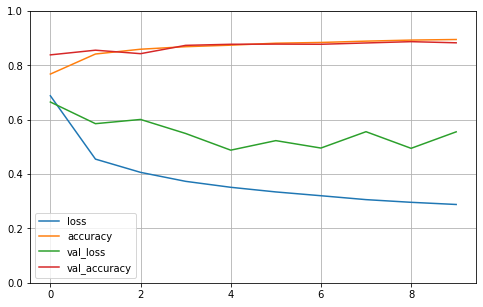

In [7]:
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.show()

plot_learning_curves(history)

# 1.参数众多，训练不充分
# 2.梯度消失 -> 链式法则 -> 复合函数f(g(x))
#   selu缓解梯度消失

In [8]:
model.evaluate(x_test_scaled, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.6405 - accuracy: 0.8741


[0.6404784917831421, 0.8741000294685364]